# 2 Single Scale Lucas-Kanada Optical Flow

## 2.1 Keypoint Detection: Selecting Pixels to Track


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig


### (i) Harris Corner Detector


In [3]:
def HarrisCornerDetect(Img, k=0.04, threshold=0.02):
    # Constants

    # Algorithm
    sobelx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = sig.convolve2d(Img.astype('float'), sobelx, mode='same')
    Iy = sig.convolve2d(Img.astype('float'), sobely, mode='same')
    Ixx = cv2.GaussianBlur(Ix**2, ksize=(5, 5), sigmaX=1.1)
    Ixy = cv2.GaussianBlur(Ix*Iy, ksize=(5, 5), sigmaX=1.1)
    Iyy = cv2.GaussianBlur(Iy**2, ksize=(5, 5), sigmaX=1.1)
    det = Ixx*Iyy - Ixy**2
    trace = Ixx + Iyy
    R = det - k*trace**2
    corners = []
    w = 2
    highest = np.max(R[w:-w-1, w:-w-1])
    for i in range(w, Img.shape[0]-w):
        for j in range(w, Img.shape[1]-w):
            roi = R[i-w:i+w+1, j-w:j+w+1]
            if R[i, j] >= np.max(roi):
                if R[i, j] > threshold*highest:
                    corners.append(np.array([i, j]))
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    # fig.suptitle("Derivatives")
    # ax1.imshow(det, cmap='gray')
    # ax2.imshow(trace, cmap='gray')
    # ax3.imshow(R, cmap='gray')
    # plt.show()
    return np.array(corners)


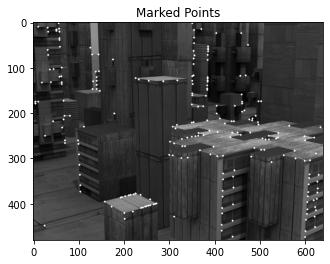

In [4]:
img = cv2.imread('../data/all-frames-colour/Urban2/frame07.png',
                 cv2.IMREAD_GRAYSCALE)
corners = HarrisCornerDetect(img)
mark_img = img.copy()
for i in corners:
    mark_img = cv2.circle(
        mark_img, i[::-1], radius=2, color=(255, 0, 0), thickness=-1)
plt.title("Marked Points")
plt.imshow(mark_img, cmap='gray')
plt.show()


### (ii) Shi-Tomasi Corner Detector


In [5]:
def ShiTomasiCornerDetect(Img, threshold=0.14):
    # Algorithm
    sobelx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = sig.convolve2d(Img.astype('float'), sobelx, mode='same')
    Iy = sig.convolve2d(Img.astype('float'), sobely, mode='same')
    Ixx = cv2.GaussianBlur(Ix**2, ksize=(5, 5), sigmaX=1.1)
    Ixy = cv2.GaussianBlur(Ix*Iy, ksize=(5, 5), sigmaX=1.1)
    Iyy = cv2.GaussianBlur(Iy**2, ksize=(5, 5), sigmaX=1.1)
    R = np.zeros(Img.shape)
    corners = []
    w = 2
    for i in range(w, Img.shape[0]-w):
        for j in range(w, Img.shape[1]-w):
            M = np.array([[Ixx[i, j], Ixy[i, j]], [Ixy[i, j], Iyy[i, j]]])
            R[i, j] = np.min(np.linalg.eigvals(M))
    highest = np.max(R[w:-w-1, w:-w-1])
    for i in range(w, Img.shape[0]-w):
        for j in range(w, Img.shape[1]-w):
            roi = R[i-w:i+w+1, j-w:j+w+1]
            if R[i, j] >= np.max(roi):
                if R[i, j] > threshold*highest:
                    corners.append(np.array([i, j]))
    return np.array(corners)


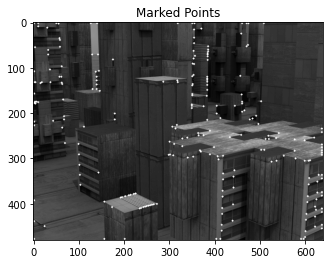

In [6]:
img = cv2.imread('../data/all-frames-colour/Urban2/frame07.png',
                 cv2.IMREAD_GRAYSCALE)
corners = ShiTomasiCornerDetect(img)
mark_img = img.copy()
for i in corners:
    mark_img = cv2.circle(
        mark_img, i[::-1], radius=2, color=(255, 0, 0), thickness=-1)
plt.title("Marked Points")
plt.imshow(mark_img, cmap='gray')
plt.show()


## 2.2 Forward-Additive Sparse Optical Flow


### Visualizing .flo files


In [7]:
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN_FLOW_THRESH = 1e7


def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()


def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d


def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - \
        np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC,
               2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - \
        np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM,
               0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


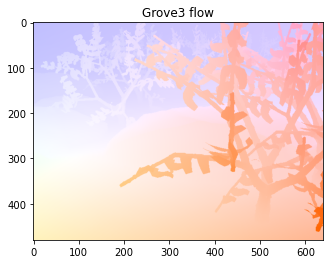

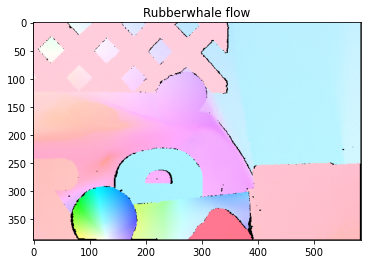

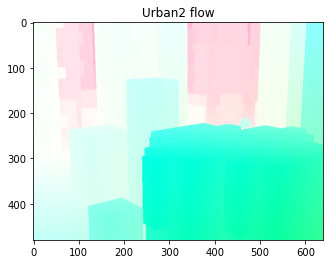

In [8]:
plt.title("Grove3 flow")
show_flow("../data/ground-truth-flow/Grove3/flow10.flo")
plt.title("Rubberwhale flow")
show_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")
plt.title("Urban2 flow")
show_flow("../data/ground-truth-flow/Urban2/flow10.flo")


In [9]:
def calc_epe(pts, vecs1, y):
    vecs2 = np.zeros(vecs1.shape)
    for i, pt in enumerate(pts):
        vecs2[i] = y[pt[0], pt[1]]
    epe = np.linalg.norm(vecs2-vecs1, axis=-1)
    return np.mean(epe)


In [10]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize, tau=0.01, detector='harris'):
    if detector == 'harris':
        corners = HarrisCornerDetect(Img1)
    else:
        corners = ShiTomasiCornerDetect(Img1)
    Img1 = Img1 / 255
    Img2 = Img2 / 255
    Img1 = cv2.GaussianBlur(Img1, (3, 3), sigmaX=1.1)
    Img2 = cv2.GaussianBlur(Img2, (3, 3), sigmaX=1.1)
    sobelx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    avgt = np.ones((3, 3))
    fx = sig.convolve2d(Img1.astype('float'), sobelx,
                        mode='same')
    fy = sig.convolve2d(Img1.astype('float'), sobely,
                        mode='same')
    ft = sig.convolve2d((Img2 - Img1).astype('float'),
                        avgt, mode='same')
    w, h = Img1.shape
    kw = windowSize//2
    # W = cv2.getGaussianKernel(ksize=kw, sigma=1)
    pts = []
    vecs = []
    for corner in corners:
        i, j = corner
        # print(i,j)
        A = np.vstack((fx[i-kw:i+kw+1, j-kw:j+kw+1].flatten(),
                       fy[i-kw:i+kw+1, j-kw:j+kw+1].flatten())).T
        b = -ft[i-kw:i+kw+1, j-kw:j+kw+1].flatten()
        b = np.reshape(b, (len(b), 1))
        if np.min(np.abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
            vec = np.matmul(np.linalg.pinv(A), b)
            pts.append((i, j))
            vecs.append(vec)
    return np.array(pts), np.array(vecs).squeeze()


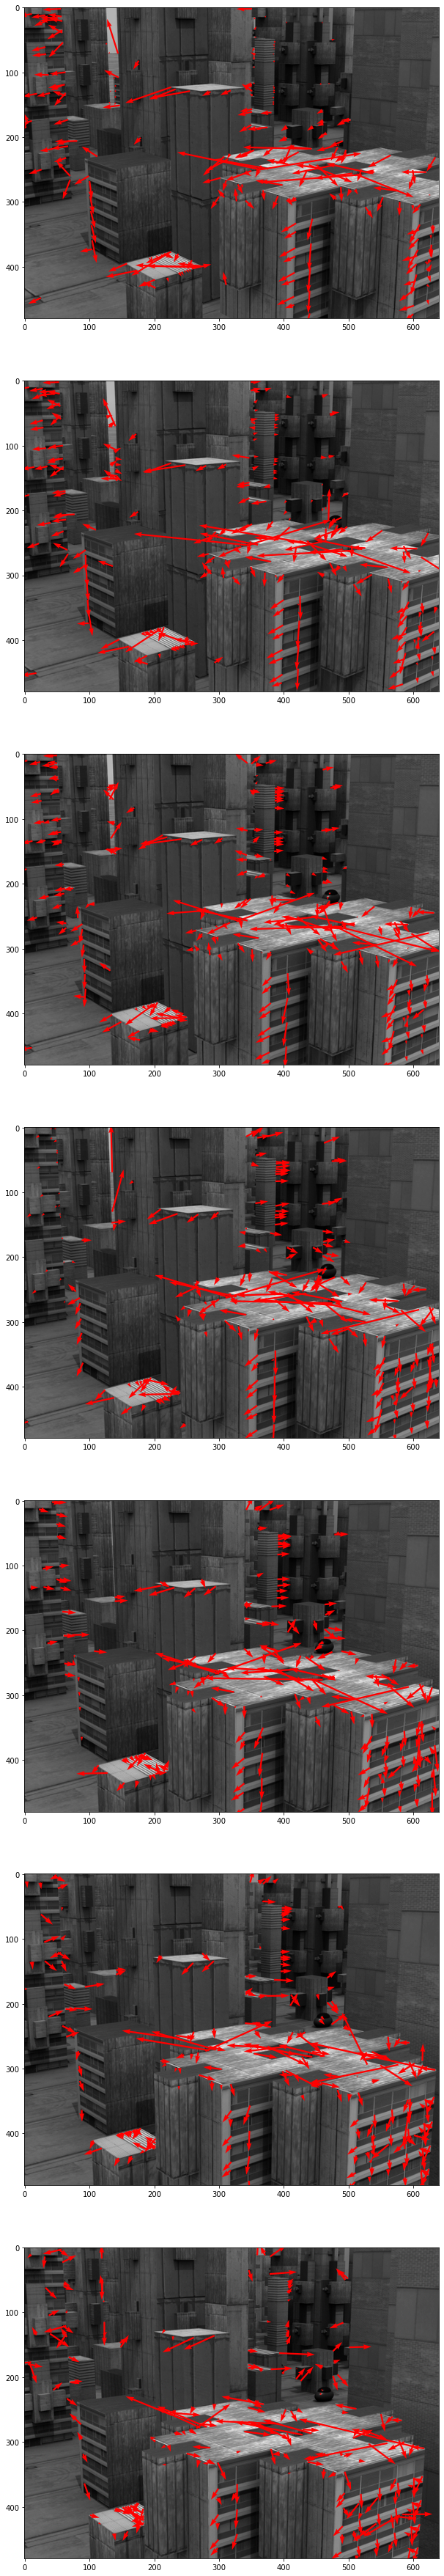

In [38]:

pictures = ["07", "08", "09", "10", "11", "12", "13", "14"]
fig, ax = plt.subplots(len(pictures)-1, 1, figsize=(48, 64))
# fig.suptitle("Derivatives")
for i, x in enumerate(pictures[:-1]):
    img1 = cv2.imread(
        f'../data/all-frames-colour/Urban2/frame{pictures[i]}.png', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(
        f'../data/all-frames-colour/Urban2/frame{pictures[i+1]}.png', cv2.IMREAD_GRAYSCALE)
    pts, vecs = LukasKanadeForwardAdditive(img1, img2, 5)
    ax[i].imshow(img1, cmap='gray')
    # print(pts.shape, vecs.shape)
    ax[i].quiver(pts[:, 1], pts[:, 0], vecs[:, 0], -vecs[:, 1], color='red')
    
plt.show()

In [12]:
for type in ["Urban2", "RubberWhale", "Grove3"]:
    img1 = cv2.imread(f'../data/all-frames-colour/{type}/frame10.png',
                      cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(f'../data/all-frames-colour/{type}/frame11.png',
                      cv2.IMREAD_GRAYSCALE)
    pts, vecs = LukasKanadeForwardAdditive(img1, img2, 5)
    flow = read_flow(f"../data/ground-truth-flow/{type}/flow10.flo")
    epe = calc_epe(pts, vecs, flow)
    print("|", type, "|", epe, "|", len(pts), "|")


| Urban2 | 10.280465324056696 | 226 |
| RubberWhale | 155408092.0448774 | 91 |
| Grove3 | 2.9157314665210223 | 908 |


# 3 Multi-Scale Coarse-to-fine Optical Flow


In [13]:
def DenseLucasKanade(Img1, Img2, windowSize, tau=0.01, detector='harris'):
    if detector == 'harris':
        corners = HarrisCornerDetect(Img1)
    else:
        corners = ShiTomasiCornerDetect(Img1)
    Img1 = Img1 / 255
    Img2 = Img2 / 255
    Img1 = cv2.GaussianBlur(Img1, (3, 3), sigmaX=1.1)
    Img2 = cv2.GaussianBlur(Img2, (3, 3), sigmaX=1.1)
    sobelx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    avgt = np.ones((3, 3))
    fx = sig.convolve2d(Img1.astype('float'), sobelx,
                        mode='same')
    fy = sig.convolve2d(Img1.astype('float'), sobely,
                        mode='same')
    ft = sig.convolve2d((Img2 - Img1).astype('float'),
                        avgt, mode='same')
    w, h = Img1.shape
    kw = windowSize//2
    # W = cv2.getGaussianKernel(ksize=kw, sigma=1)
    u = np.zeros((w, h))
    v = np.zeros((w, h))
    for i in range(kw, w-kw-1):
        for j in range(kw, h-kw-1):
            # print(i,j)
            A = np.vstack((fx[i-kw:i+kw+1, j-kw:j+kw+1].flatten(),
                           fy[i-kw:i+kw+1, j-kw:j+kw+1].flatten())).T
            b = -ft[i-kw:i+kw+1, j-kw:j+kw+1].flatten()
            b = np.reshape(b, (len(b), 1))
            if np.min(np.abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                vec = np.matmul(np.linalg.pinv(A), b)
                u[i, j] = vec[0]
                v[i, j] = vec[1]
    return u, v


In [62]:
def OpticalFlowRefine(Img1, Img2, windowSize, u0, v0, tau=0.01, detector='harris'):
    if detector == 'harris':
        corners = HarrisCornerDetect(Img1)
    else:
        corners = ShiTomasiCornerDetect(Img1)
    Img1 = Img1 / 255
    Img2 = Img2 / 255
    Img1 = cv2.GaussianBlur(Img1, (3, 3), sigmaX=1.1)
    Img2 = cv2.GaussianBlur(Img2, (3, 3), sigmaX=1.1)
    sobelx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    avgt = np.ones((3, 3))
    fx = sig.convolve2d(Img1.astype('float'), sobelx,
                        mode='same')
    fy = sig.convolve2d(Img1.astype('float'), sobely,
                        mode='same')
    # ft = sig.convolve2d((Img2 - Img1).astype('float'),
    # avgt, mode='same')
    w, h = Img1.shape
    kw = windowSize//2
    # W = cv2.getGaussianKernel(ksize=kw, sigma=1)
    u = u0
    v = v0
    print(Img1.shape, u0.shape)
    for i in range(kw, w-kw-1):
        for j in range(kw, h-kw-1):
            # print(i,j)
            c1 = Img1[i-kw:i+kw+1, j-kw:j+kw+1]
            if i-kw+u0[i,j] < 0 or i+kw+1+u0[i,j] > w:
                continue
            if j-kw+v0[i,j] < 0 or j+kw+1+v0[i,j] > h:
                continue
            c2 = Img2[int(i-kw+u0[i,j]):int(i+kw+1+u0[i,j]), int(j-kw+v0[i,j]):int(j+kw+1+v0[i,j])]
            # ft = sig.convolve2d((c2 - c1).astype('float'),
            #                     avgt, mode='same')
            A = np.vstack((fx[i-kw:i+kw+1, j-kw:j+kw+1].flatten(),
                           fy[i-kw:i+kw+1, j-kw:j+kw+1].flatten())).T
            b = -(c2-c1).flatten()
            b = np.reshape(b, (len(b), 1))
            if np.min(np.abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                vec = np.matmul(np.linalg.pinv(A), b)
                u[i, j] += vec[0]
                v[i, j] += vec[1]
    return u, v


In [73]:
def MuliScaleLucasKanade(Img1, Img2, windowSize, numLevels):
    pyramid1 = []
    pyramid2 = []
    I1, I2 = Img1, Img2
    for i in range(numLevels):
        pyramid1.append(I1)
        pyramid2.append(I2)
        I1 = cv2.GaussianBlur(I1, ksize=(3,3), sigmaX=1.1)
        I2 = cv2.GaussianBlur(I2, ksize=(3,3), sigmaX=1.1)
        I1 = cv2.resize(I1, dsize=(I1.shape[0]//2, I1.shape[1]//2)[::-1])
        I2 = cv2.resize(I2, dsize=(I2.shape[0]//2, I2.shape[1]//2)[::-1])
    pyramid1.reverse()
    pyramid2.reverse()
    u, v = DenseLucasKanade(pyramid1[0], pyramid2[0], windowSize=windowSize)
    for i in range(1, numLevels):
        U = u.copy()
        V = v.copy()
        u = cv2.resize(u, pyramid1[i].shape[::-1],
                       interpolation=cv2.INTER_LINEAR)
        v = cv2.resize(v, pyramid2[i].shape[::-1],
                       interpolation=cv2.INTER_LINEAR)
        u *= 2
        v *= 2
        u, v = OpticalFlowRefine(pyramid1[i], pyramid2[i], windowSize=windowSize, u0=u, v0=v)
        # UU = cv2.resize(U, Img1.shape[::-1],  interpolation=cv2.INTER_LINEAR)
        # VV = cv2.resize(V, Img1.shape[::-1],  interpolation=cv2.INTER_LINEAR)
        # UU *= 2 ** (numLevels-i)
        # UU *= 2 ** (numLevels-i)
        # pts = HarrisCornerDetect(img1)
        # vecs = np.zeros(pts.shape)
        # for j, pt in enumerate(pts):
        #     x,y = pt
        #     vecs[j,0] = UU[x,y]
        #     vecs[j,1] = VV[x,y]
        # flow = read_flow(f"../data/ground-truth-flow/Grove3/flow10.flo")
        # epe = calc_epe(pts, vecs, flow)
        # print(i, "|",  epe)
    return u, v

(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)
(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)
(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)
(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)
(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)
(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)
(48, 73) (48, 73)
(97, 146) (97, 146)
(194, 292) (194, 292)
(388, 584) (388, 584)


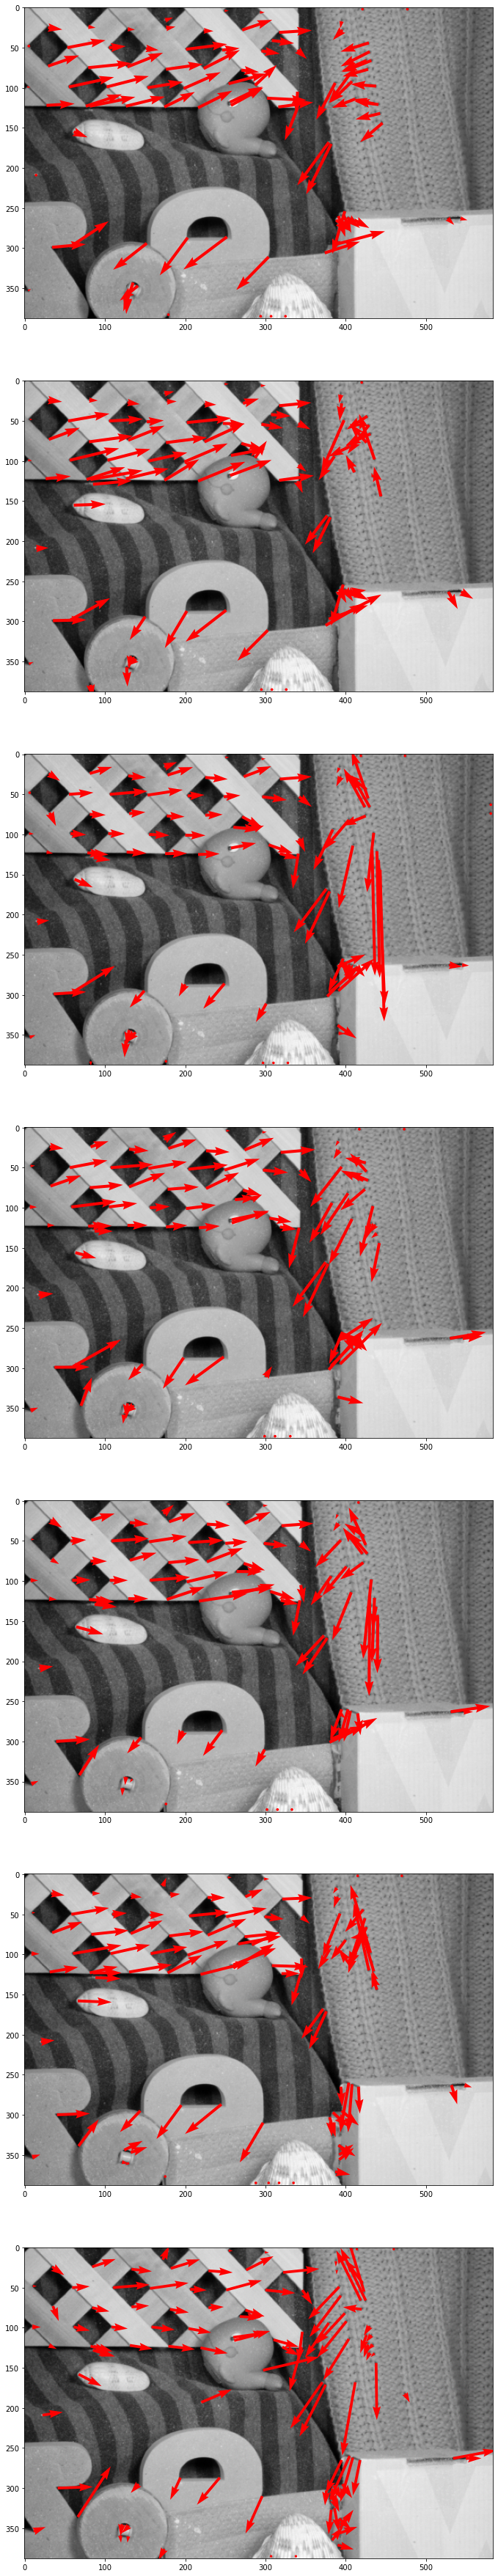

In [74]:
pictures = ["07", "08", "09", "10", "11", "12", "13", "14"]
fig, ax = plt.subplots(len(pictures)-1, 1, figsize=(48, 64))
# fig.suptitle("Derivatives")
for i, x in enumerate(pictures[:-1]):
    img1 = cv2.imread(
        f'../data/all-frames-colour/RubberWhale/frame{pictures[i]}.png', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(
        f'../data/all-frames-colour/RubberWhale/frame{pictures[i+1]}.png', cv2.IMREAD_GRAYSCALE)
    u, v = MuliScaleLucasKanade(img1, img2, 5, 5)
    pts = HarrisCornerDetect(img1)
    U = np.zeros(pts.shape[0])
    V = np.zeros(pts.shape[0])
    for j, pt in enumerate(pts):
        x,y = pt
        U[j] = u[x,y]
        V[j] = v[x,y]
    ax[i].imshow(img1, cmap='gray')
    # print(pts.shape, vecs.shape)
    ax[i].quiver(pts[:, 1], pts[:, 0], U, -V, color='red')
plt.show()

In [71]:

for type in ["Grove3"]:
    img1 = cv2.imread(f'../data/all-frames-colour/{type}/frame10.png',
                      cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(f'../data/all-frames-colour/{type}/frame11.png',
                      cv2.IMREAD_GRAYSCALE)
    u, v = MuliScaleLucasKanade(img1, img2, 5, 5)
    pts = HarrisCornerDetect(img1)
    vecs = np.zeros(pts.shape)
    for i, pt in enumerate(pts):
        x,y = pt
        vecs[i,0] = u[x,y]
        vecs[i,1] = v[x,y]
    flow = read_flow(f"../data/ground-truth-flow/{type}/flow10.flo")
    epe = calc_epe(pts, vecs, flow)
    print("|", type, "|", epe, "|", len(pts), "|")

(30, 40) (30, 40)
1 | 57.61202580383675
(60, 80) (60, 80)
2 | 43.121436344361854
(120, 160) (120, 160)
3 | 26.299489956076158
(240, 320) (240, 320)
4 | 14.456364969127092
(480, 640) (480, 640)
5 | 7.613147237976429
| Grove3 | 4.443659526432864 | 908 |
